# Optimisation Project

- Garrett Scooter _(gas3254)_
- Chaitra Setty _(cs63687)_
- Rohitashwa Chakraborty _(rc47878)_
- Shreya Bhootda _(sb5863)_

In [3]:
import numpy as np
import gurobi as gb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from numpy.random import normal, randint
from scipy.stats import binom

tqdm.pandas()
%matplotlib inline

## Defining Parameters

#### First Class

In [4]:
FC = {
    'seats': 20,
    'price_low': 425,
    'purchase_proba_low': 0.08,
    'price_high': 500,
    'purchase_proba_high': 0.04,
    'probability_showup': 0.97,
}

#### Coach

In [5]:
COACH = {
    'seats': 100,
    'price_low': 300,
    'purchase_proba_low': 0.65,
    'price_high': 350,
    'purchase_proba_high': 0.30,
    'probability_showup': 0.95,
}

#### Global

In [6]:
T = 365 # Days to flight

OVERBOOKING_COUNT = 5 # Number of seats overbooked in Coach
UPGRADE_COST = 50 # Cost of upgrading a Coach ticket to First-Class
BUMP_COST = 425 # Cost to airlines to cancell a ticket

discount_factor = 0.15 # Discount factor
DELTA = 1/(1+(discount_factor/365)) # Discount factor for each day
DELTA

0.999589209913734

In [7]:
# + 1 for the buffer. 0->N is N+1 values
total_coach_seats = COACH['seats']+ OVERBOOKING_COUNT + 1
total_fc_seats = FC['seats'] + 1
total_days = T + 1

In [8]:
V = np.zeros(( total_coach_seats, total_fc_seats, total_days )) # Value Matrix

U = V.copy()   # Utility matrix

V.shape, U.shape

((106, 21, 366), (106, 21, 366))

## Question 1

#### Cost Lookup

In [9]:
PRICING_OPTIONS = [
    (COACH['price_low'], COACH['purchase_proba_low'], FC['price_low'], FC['purchase_proba_low']),    #COACH_LOW_FC_LOW
    (COACH['price_low'], COACH['purchase_proba_low'], FC['price_high'], FC['purchase_proba_high']),  #COACH_LOW_FC_HIGH
    (COACH['price_high'], COACH['purchase_proba_high'], FC['price_low'], FC['purchase_proba_low']),  #COACH_HIGH_FC_LOW
    (COACH['price_high'], COACH['purchase_proba_high'], FC['price_high'], FC['purchase_proba_high']), #COACH_HIGH_FC_HIGH
    # No Sale Strategy pricing options
    (0, 0, FC['price_low'], FC['purchase_proba_low']), #COACH_NOSALE_FC_LOW
    (0, 0, FC['price_high'], FC['purchase_proba_high']) #COACH_NOSALE_FC_HIGH
]


decision_lookup = {
    0: 'COACH_LOW_FC_LOW',
    1: 'COACH_LOW_FC_HIGH',
    2: 'COACH_HIGH_FC_LOW',
    3: 'COACH_HIGH_FC_HIGH',
    # No Sale Strategy pricing options
    4: 'COACH_NOSALE_FC_LOW',
    5: 'COACH_NOSALE_FC_HIGH'
}

In [10]:
def NET_PRESENT_VALUE(c, fc, t, coach_price, coach_purchase_proba, fc_price, fc_purchase_proba, V):
    decision = None
    if c < COACH['seats'] + OVERBOOKING_COUNT and fc < FC['seats']: # seats available
        value = (
            (0 + DELTA*V[c, fc, t+1] ) * (1 - coach_purchase_proba ) * (1 - fc_purchase_proba)  # Neither tickets sold
            + (coach_price + DELTA*V[c+1, fc, t+1] ) * (coach_purchase_proba ) * (1 - fc_purchase_proba) # Only Coach tickets sold
            + (fc_price + DELTA*V[c, fc+1, t+1] ) * (1 - coach_purchase_proba ) * (fc_purchase_proba) # Only FC tickets sold
            + (coach_price + fc_price + DELTA*V[c+1, fc+1, t+1] ) * (coach_purchase_proba ) * (fc_purchase_proba) # Both tickets sold
        )

    elif c < COACH['seats'] + OVERBOOKING_COUNT and fc >= FC['seats']: # coach seats available, fc seats not
        value = (
            (0 + DELTA*V[c, fc, t+1] ) * (1 - coach_purchase_proba )    # Neither tickets sold
            + (coach_price + DELTA*V[c+1, fc, t+1] ) * (coach_purchase_proba )  # Only Coach tickets sold
        )

    elif c >= COACH['seats'] + OVERBOOKING_COUNT and fc < FC['seats']: # coach seats not available, fc seats available
        value = (
            (0 + DELTA*V[c, fc, t+1] ) * (1 - fc_purchase_proba)    # Neither tickets sold
            + (fc_price + DELTA*V[c, fc+1, t+1] ) * (fc_purchase_proba) # Only FC tickets sold
        )
    else: # c >= COACH['seats'] + OVERBOOKING_COUNT and fc >= FC['seats'] # No more seats available
        value = DELTA*V[c, fc, t+1] # No tickets sold
        decision = -1 # No more seats available

    return value, decision

def OPTIMAL_PRICE(c, fc, t, V, mode = 'normal'):
    pricing = []
    pricing_options = PRICING_OPTIONS[:4] if mode == 'normal' else PRICING_OPTIONS
    for coach_price, coach_purchase_proba, fc_price, fc_purchase_proba in pricing_options:
        value, decision = NET_PRESENT_VALUE(c, fc, t, coach_price, coach_purchase_proba, fc_price, fc_purchase_proba, V)
        pricing.append(value)
    pricing = np.array(pricing)
    return np.max(pricing), np.argmax(pricing) if decision != -1 else decision

#### Overbooking Function

In [11]:
def overbook(overbook_count, mode = 'normal'):
    global OVERBOOKING_COUNT
    OVERBOOKING_COUNT = overbook_count
    
    # + 1 for the buffer. 0->N is N+1 values
    total_coach_seats = COACH['seats']+ OVERBOOKING_COUNT + 1
    total_fc_seats = FC['seats'] + 1
    total_days = T + 1

    V = np.zeros(( total_coach_seats, total_fc_seats, total_days )) # Value Matrix
    U = np.zeros(( total_coach_seats, total_fc_seats, total_days )) # Optimal Choice matrix

    # print(V.shape, U.shape)

    # Cost on final day.
    for coach_booked in range(101,total_coach_seats): # no cost till 100 coach seats
        for fc_booked in range(total_fc_seats):
            for coach in range(coach_booked+1):
                for fc in range(fc_booked+1):
                    if coach > COACH['seats']:
                        # First Uprade Coach customers to First-Class.
                        excess_coach = coach - COACH['seats']
                        to_fc = min( FC['seats']-fc , excess_coach)
                        # minimum of seats available in FC and overbooked seats will be updared to FC
                        excess_coach -= to_fc # Coach customers left..need to be dropped
                        
                        cost_to_company = (to_fc * UPGRADE_COST) + (excess_coach * BUMP_COST)
                    
                        # Probability of i / coach COACH customers show up
                        prob_coach = binom.pmf(coach, coach_booked, COACH['probability_showup'])
                        # Probability of j / fc FC customers show up
                        prob_fc = binom.pmf( fc, fc_booked, FC['probability_showup'])
                    
                        V[coach_booked, fc_booked, T] -= cost_to_company * prob_coach * prob_fc


# Calculate the optimal price and optimal choice
    for t in reversed(range(T)):
        for coach in range(total_coach_seats):
            for fc in range(total_fc_seats):
                V[coach, fc, t], U[coach, fc, t] = OPTIMAL_PRICE(coach, fc, t, V, mode)
            
    return V, U

In [12]:
V_5, U_5 = overbook(5)
print(f'Optimal Profit: $ {round(V_5[0,0,0],2)}')

Optimal Profit: $ 42242.86


## Question 2

In [13]:
rev_list = np.zeros(10)
for overbook_count in range(6,16):
    V, _ = overbook(overbook_count)
    rev_list[overbook_count - 6] = V[0,0,0]
    print('Revenue:',np.round(V[0,0,0], 2), 'Overbooked seats:', overbook_count)
print('Most profitable to overbook:',np.argmax(rev_list) + 6,'seats with $ ',np.round(np.max(rev_list), 2),'in profit')


Revenue: 42368.87 Overbooked seats: 6
Revenue: 42444.24 Overbooked seats: 7
Revenue: 42482.21 Overbooked seats: 8
Revenue: 42496.11 Overbooked seats: 9
Revenue: 42495.97 Overbooked seats: 10
Revenue: 42488.26 Overbooked seats: 11
Revenue: 42477.0 Overbooked seats: 12
Revenue: 42464.6 Overbooked seats: 13
Revenue: 42452.36 Overbooked seats: 14
Revenue: 42440.94 Overbooked seats: 15
Most profitable to overbook: 9 seats with $  42496.11 in profit


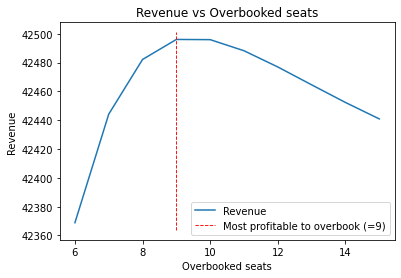

In [14]:
plt.plot(list(range(6,16)), rev_list, label='Revenue')
plt.vlines(np.argmax(rev_list) + 6, np.min(rev_list)-5, np.max(rev_list)+ 5, colors='r', linestyles='dashed', linewidth= 0.9, label=f'Most profitable to overbook (={np.argmax(rev_list) + 6})')
plt.xlabel('Overbooked seats')
plt.ylabel('Revenue')
plt.title('Revenue vs Overbooked seats')
plt.legend()
plt.show()

## Question 3

In [15]:
rev_list_flex = np.zeros(10)
for overbook_count in range(6,16):
    V, _ = overbook(overbook_count, mode= 'flex')
    rev_list_flex[overbook_count - 6] = V[0,0,0]
    print('Revenue:',np.round(V[0,0,0], 2), 'Overbooked seats:', overbook_count)
print('Most profitable to overbook:',np.argmax(rev_list_flex) + 6,'seats with $ ',np.round(np.max(rev_list_flex), 2),'in profit')


Revenue: 42368.87 Overbooked seats: 6
Revenue: 42444.24 Overbooked seats: 7
Revenue: 42482.21 Overbooked seats: 8
Revenue: 42496.11 Overbooked seats: 9
Revenue: 42500.46 Overbooked seats: 10
Revenue: 42501.96 Overbooked seats: 11
Revenue: 42502.45 Overbooked seats: 12
Revenue: 42502.6 Overbooked seats: 13
Revenue: 42502.65 Overbooked seats: 14
Revenue: 42502.67 Overbooked seats: 15
Most profitable to overbook: 15 seats with $  42502.67 in profit


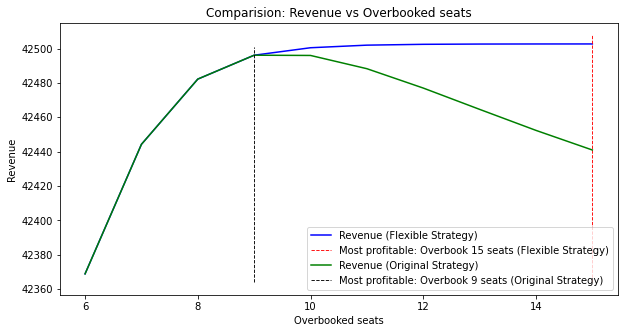

In [16]:
plt.figure(figsize=(10,5))
plt.plot(list(range(6,16)), rev_list_flex, label='Revenue (Flexible Strategy)', color='b')
plt.vlines(np.argmax(rev_list_flex) + 6, np.min(rev_list_flex)-5, np.max(rev_list_flex)+ 5, colors='r', linestyles='dashed', linewidth= 0.9, label=f'Most profitable: Overbook {np.argmax(rev_list_flex) + 6} seats (Flexible Strategy)')

plt.plot(list(range(6,16)), rev_list, label='Revenue (Original Strategy)', color='g')
plt.vlines(np.argmax(rev_list) + 6, np.min(rev_list)-5, np.max(rev_list)+ 5, colors='black', linestyles='dashed', linewidth= 0.9, label=f'Most profitable: Overbook {np.argmax(rev_list) + 6} seats (Original Strategy)')
plt.xlabel('Overbooked seats')
plt.ylabel('Revenue')
plt.title('Comparision: Revenue vs Overbooked seats')
plt.legend()
plt.show()

Therefore, we observe that upto 9 seats of overbooking, both strategies perform equally well.

However, as the margin for overbooking increases, the second strategy outperforms the first.

One must note that the second strategy does not have a visible upper bound in the trend visualised above (The strategy plateaus beyond 15 seats limit of overbooking). 

Therefore, if the airlines mandates upto 20 seats of overbooking, the second strategy will earn maximum revenue at a overbooking limit of 20 seats.

In [17]:
V_9, _ = overbook(9)
print(f'Strategy - Originial (Overbook: 9):\n\tOptimal Revenue: $ {round(V_9[0,0,0],2)}')

Vf_20, _ = overbook(20, 'flex')
print(f'Strategy - Flex (Overbook: 20):\n\tOptimal Revenue: $ {round(Vf_20[0,0,0],2)}')


Strategy - Originial (Overbook: 9):
	Optimal Revenue: $ 42496.11
Strategy - Flex (Overbook: 20):
	Optimal Revenue: $ 42502.67


Therefore, The second strategy ( no sale of coach allowed), is the most efficient.

## Question 4

In [40]:
def simulation(U, mode='normal', verbose = False):
    coach_ticket = 0
    fc_ticket = 0
    revenue_vec = np.zeros(T + 1)
    tickets_sold = np.zeros((T + 1, 2))

    for t in range(T+1):
        revenue = 0
        decision = int(U[coach_ticket, fc_ticket, t])
        if decision == -1:
            revenue_vec[t:] = [revenue_vec[t-1]] * (T + 1 - t)
            tickets_sold[t:, :] = [[coach_ticket, fc_ticket]] * (T + 1 - t)
            break
        coach_price, coach_purchase_proba, fc_price, fc_purchase_proba = PRICING_OPTIONS[decision]

        is_coach_sold = int(np.random.random(1) <= coach_purchase_proba)
        is_fc_sold = int(np.random.random(1) <= fc_purchase_proba)

        if coach_ticket + is_coach_sold <= COACH['seats']+ OVERBOOKING_COUNT:
            coach_ticket += is_coach_sold
            revenue +=  coach_price * is_coach_sold

        if fc_ticket + is_fc_sold <= FC['seats']:
            fc_ticket += is_fc_sold
            revenue += fc_price * is_fc_sold

        revenue_vec[t] = revenue*(DELTA**t) + revenue_vec[t-1]
        tickets_sold[t, :] = [coach_ticket, fc_ticket]


    if verbose:
        plt.figure(figsize=(10,5))
        plt.stackplot(range(-(T+1),0), tickets_sold.T, labels=['Coach Tickets Booked', 'FC Tickets Booked'], colors=['b','y'])
        plt.hlines(COACH['seats'], -(T+1), 0, colors='c', linestyles='dashed', label='Coach Seats', linewidth=0.9)
        plt.hlines(COACH['seats']+OVERBOOKING_COUNT, -(T+1), 0, colors='r', linestyles='dashed', label='Overbooking Limit', linewidth=0.9)
        plt.xlabel('Time(days)')
        plt.ylabel('Seat Occupancy')
        plt.title(f'Seat on a Plane, Revenue: ${np.round(revenue_vec[-1], 2)}\n Overbooking: {OVERBOOKING_COUNT}, Mode: {mode}')
        plt.legend(loc = 4)
        plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(range(-(T+1),0), revenue_vec, label='Revenue')
        plt.xlabel('Time(days)')
        plt.ylabel('Revenue')
        plt.title(f'Revenue trend, Overbooking: {OVERBOOKING_COUNT}, Mode: {mode}')
        plt.legend(loc = 4)
        plt.show()

    return revenue_vec, tickets_sold


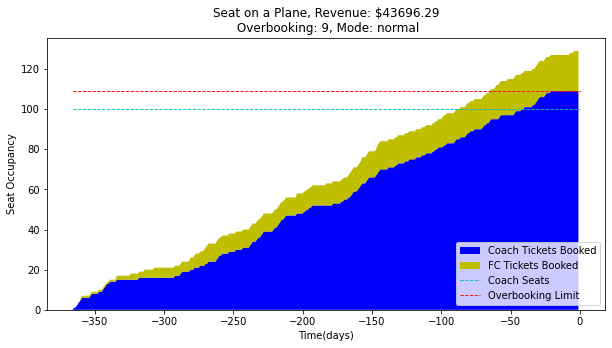

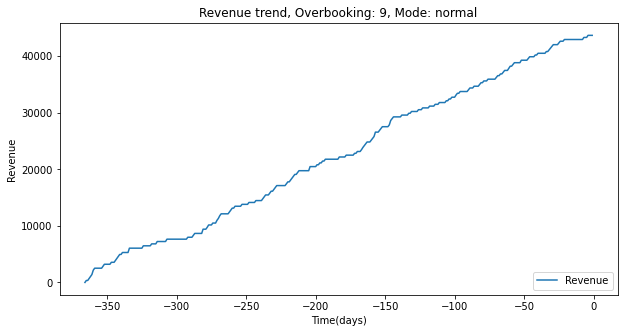

In [47]:
_, U = overbook(9)
revenue_vec, tickets_sold = simulation(U, verbose=True)


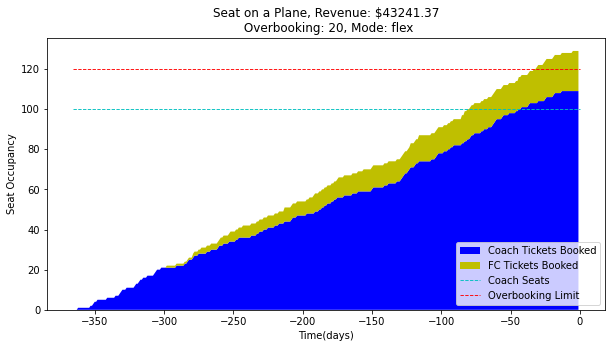

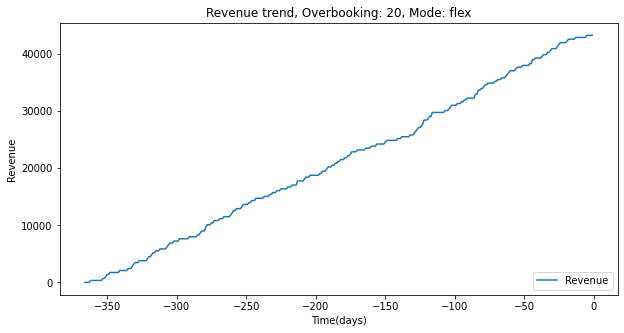

In [42]:
_, U = overbook(20, 'flex')
revenue_vec, tickets_sold = simulation(U, mode = 'flex', verbose=True)

#### Monte Carlo Simulation

In [44]:
def monte_carlo_simulation(overbook_count, mode='normal', n_sim=100000, verbose = False):
    _, U = overbook(overbook_count, mode)
    
    sim_revenue = np.zeros(n_sim)
    sim_tickets = np.zeros((n_sim,2))
    sim_overbooking = np.zeros((n_sim,2))
    overbooking_cost = np.zeros(n_sim)

    is_bumped = 0
    is_overbooked = 0


    for i in tqdm(range(n_sim)):
        revenue_vec, tickets_sold = simulation(U)
        tickets_sold = tickets_sold[-1,:]

        if sum(tickets_sold) > (COACH['seats'] + FC['seats']):
            is_overbooked += 1
        
        coach_show = np.sum(np.random.random(int(tickets_sold[0])) < COACH['probability_showup'])
        fc_show = np.sum(np.random.random(int(tickets_sold[1])) < FC['probability_showup'])
        
        if (coach_show + fc_show) > (COACH['seats'] + FC['seats']):
            is_bumped += 1
        
        ## Overbooking cost
        to_fc = excess_coach = 0
        if coach_show > COACH['seats']:
            # First Uprade Coach customers to First-Class.
            excess_coach = coach_show - COACH['seats']
            to_fc = min( FC['seats']-fc_show , excess_coach)
            # minimum of seats available in FC and overbooked seats will be updared to FC
            excess_coach -= to_fc # Coach customers left..need to be dropped
            
            overbooking_cost[i] = (to_fc * UPGRADE_COST) + (excess_coach * BUMP_COST)
        
        

        sim_revenue[i] = revenue_vec[-1]
        sim_tickets[i,:] = tickets_sold
        sim_overbooking[i,:] = [to_fc, excess_coach]

    print(f'Coach overbooked : {np.round((is_overbooked/n_sim)*100, 3)}% of the times')
    print(f'Passengers Kicked: {np.round((is_bumped/n_sim)*100, 3)}% of the times')
    print(f'Avg. Overbooking Cost: ${np.round(np.mean(overbooking_cost), 2)}')
    print(f'Avg. Revenue: ${np.round(np.mean(sim_revenue), 2)}')
    print(f'Std. Revenue: ${np.round(np.std(sim_revenue), 2)}')
    tickets_sold = np.round(np.mean(sim_tickets, 0), 2)
    print(f'Avg. Tickets Sold:\n  Coach:{tickets_sold[0]}\n  FC:{tickets_sold[1]}')

    if verbose:
        plt.hist(sim_revenue, bins=50, density=True, label='Revenue')
        sim_mean, sim_std = np.mean(sim_revenue), np.std(sim_revenue)
        y_min, y_max = plt.ylim()
        plt.vlines(sim_mean - 1.96*sim_std, y_min, y_max, label='Lower C.I.', linestyles='dashed', linewidth=0.9, color='black')
        plt.vlines(sim_mean, y_min, y_max, label='Avg. Revenue', linestyles='dashed', linewidth=0.9, color='r')
        plt.vlines(sim_mean + 1.96*sim_std, y_min, y_max, label='Upper C.I', linestyles='dashed', linewidth=0.9, color='black')
        
        expected_revenue = 42242.86 if mode == 'normal' else 42502.67
        # plt.vlines(expected_revenue, y_min, y_max, label='Expected. Revenue', linestyles='dashed', linewidth=0.9, color='g')
        plt.xlabel('Revenue')
        plt.ylabel('Probability')
        plt.title(f'Revenue Distribution, Overbooking: {overbook_count}, Mode: {mode}')
        plt.legend()
        plt.show()
    return sim_revenue, sim_overbooking

ORIGINAL STRATEGY


100%|██████████| 100000/100000 [03:33<00:00, 468.18it/s]


Coach overbooked : 99.995% of the times
Passengers Kicked: 72.589% of the times
Avg. Overbooking Cost: $1038.09
Avg. Revenue: $43397.78
Std. Revenue: $853.4
Avg. Tickets Sold:
  Coach:108.44
  FC:19.55


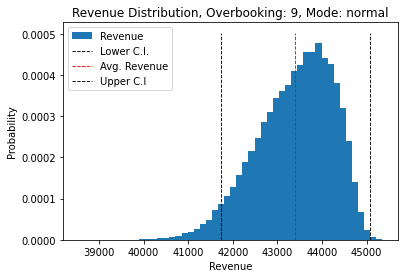

FLEXIBLE STRATEGY


100%|██████████| 100000/100000 [03:37<00:00, 460.39it/s]


Coach overbooked : 100.0% of the times
Passengers Kicked: 77.866% of the times
Avg. Overbooking Cost: $1243.51
Avg. Revenue: $43553.88
Std. Revenue: $898.86
Avg. Tickets Sold:
  Coach:109.07
  FC:19.49


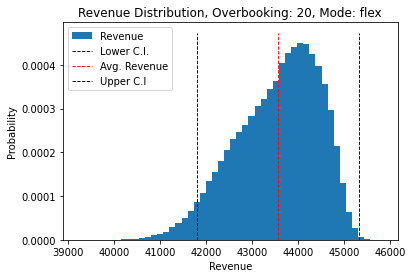

In [45]:
print("ORIGINAL STRATEGY")
revenue_orig, overbook_orig = monte_carlo_simulation(9, verbose=True)
print("FLEXIBLE STRATEGY")
revenue_flex, overbook_flex = monte_carlo_simulation(20, 'flex', verbose=True)

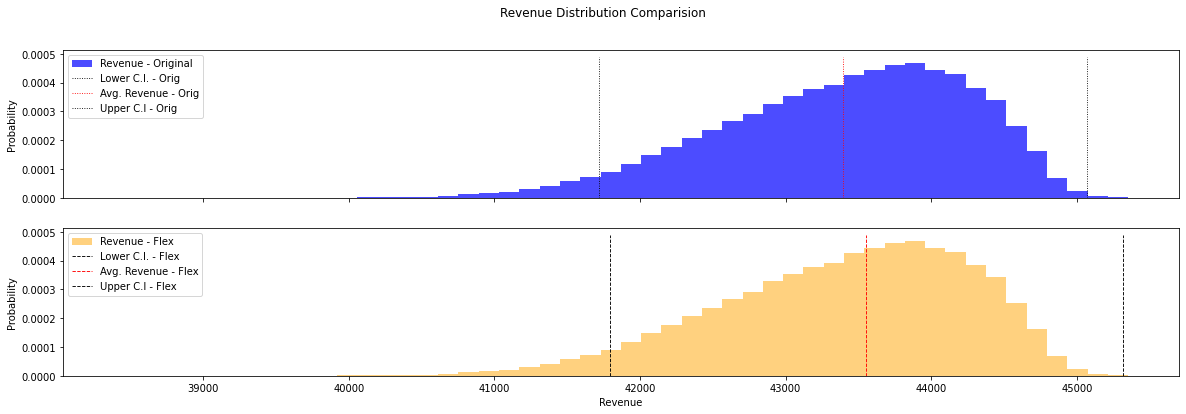

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(20, 6), sharey=True, sharex=True)

ax[0].hist(revenue_orig, bins=50, density=True, label='Revenue - Original', alpha=0.7, color='b')
sim_mean, sim_std = np.mean(revenue_orig), np.std(revenue_orig)
y_min, y_max = plt.ylim()
ax[0].vlines(sim_mean - 1.96*sim_std, y_min, y_max, label='Lower C.I. - Orig', linestyles='dotted', linewidth=0.9, color='black')
ax[0].vlines(sim_mean, y_min, y_max, label='Avg. Revenue - Orig', linestyles='dotted', linewidth=0.9, color='red')
ax[0].vlines(sim_mean + 1.96*sim_std, y_min, y_max, label='Upper C.I - Orig', linestyles='dotted', linewidth=0.9, color='black')
ax[0].set_ylabel('Probability')
ax[0].legend(loc = 2)

ax[1].hist(revenue_orig, bins=50, density=True, label='Revenue - Flex', alpha=0.5, color='orange')
sim_mean, sim_std = np.mean(revenue_flex), np.std(revenue_flex)
ax[1].vlines(sim_mean - 1.96*sim_std, y_min, y_max, label='Lower C.I. - Flex', linestyles='dashed', linewidth=0.9, color='black')
ax[1].vlines(sim_mean, y_min, y_max, label='Avg. Revenue - Flex', linestyles='dashed', linewidth=0.9, color='r')
ax[1].vlines(sim_mean + 1.96*sim_std, y_min, y_max, label='Upper C.I - Flex', linestyles='dashed', linewidth=0.9, color='black')
ax[1].set_ylabel('Probability')
ax[1].legend(loc = 2)

plt.xlabel('Revenue')
plt.suptitle(f'Revenue Distribution Comparision')
plt.show()

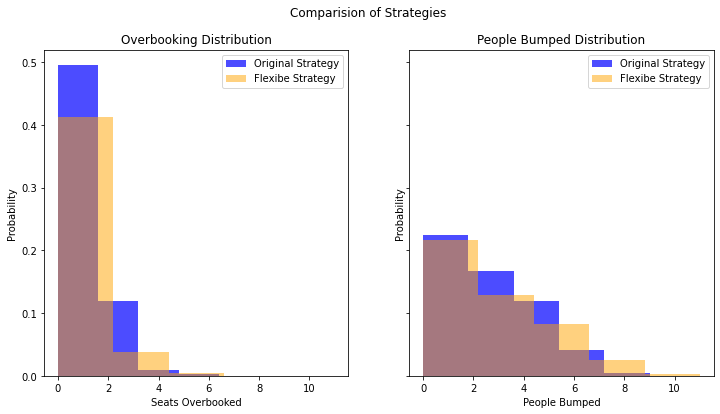

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].hist(overbook_orig[:,0], bins=5, density=True, label='Original Strategy', alpha=0.7, color='b')
ax[0].hist(overbook_flex[:,0], bins=5, density=True, label='Flexibe Strategy', alpha=0.5, color='orange')
ax[0].set_xlabel('Seats Overbooked')
ax[0].set_ylabel('Probability')
ax[0].set_title(f'Overbooking Distribution')
ax[0].legend()

ax[1].hist(overbook_orig[:,1], bins=5, density=True, label='Original Strategy', alpha=0.7, color='b')
ax[1].hist(overbook_flex[:,1], bins=5, density=True, label='Flexibe Strategy', alpha=0.5, color='orange')
ax[1].set_xlabel('People Bumped')
ax[1].set_ylabel('Probability')
ax[1].set_title(f'People Bumped Distribution')
ax[1].legend()

plt.suptitle('Comparision of Strategies')
plt.show()

***
***